# Bank Marketing Project 

dataset source: https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [324]:
train_df = pd.read_csv('bank_marketing_train.csv', sep=';')
test_df = pd.read_csv('bank_marketing_test.csv', sep=';')

In [325]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [326]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [327]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [328]:
test_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


The train file holds 90% of the data and the test file holds the other 10% (they both include the target column, "y"). I think that ratio is a little too high and an 80/20 split would allow for a more thorough test set. Subsequently, I'm going to concatenate these two files and then perform a new train-test split.

In [329]:
rejoined_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
rejoined_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Tidying up the datetime columns and performing the train-test-split

Before doing a train-test-split, I'd like to be able to see how the date columns work throughout the year. To that end, I'll convert them to a 'month-day' datetime column, which I can do here before the train-test-split without producing any data leakage.

In [330]:
#Making sure the 'month' column is exhaustive 
rejoined_df['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

In [331]:
#converting the 'month' column to a datetime-conversion-friendly format
month_abbr_to_num = {
    "jan": '01',
    "feb": '02',
    "mar": '03',
    "apr": '04',
    "may": '05',
    "jun": '06',
    "jul": '07',
    "aug": '08',
    "sep": '09',
    "oct": '10',
    "nov": '11',
    "dec": '12',
}
rejoined_df['month'] = rejoined_df['month'].map(month_abbr_to_num)
rejoined_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,05,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,05,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,05,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,05,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,05,198,1,-1,0,unknown,no


In [332]:
#First converting the 'day' column to a string column
rejoined_df['str_day'] = rejoined_df['day'].apply(str)

In [333]:
#Now adding in the leading zeroes before converting to datetime
# since Python wouldn't allow it when they were integers
leading_zeroes_dict = {
    '1': '01',
    '2': '02',
    '3': '03',
    '4': '04',
    '5': '05',
    '6': '06',
    '7': '07',
    '8': '08',
    '9': '09',
}
rejoined_df['str_day'] = rejoined_df['str_day'].map(leading_zeroes_dict).fillna(rejoined_df['str_day'])
#Making sure it worked
rejoined_df['str_day'].unique()

array(['05', '06', '07', '08', '09', '12', '13', '14', '15', '16', '19',
       '20', '21', '23', '26', '27', '28', '29', '30', '02', '03', '04',
       '11', '17', '18', '24', '25', '01', '10', '22', '31'], dtype=object)

In [334]:
#creating a 'month-day' column that will better help keep track of annual trends
rejoined_df['month-day'] = rejoined_df['month'] + rejoined_df['str_day']
rejoined_df['month-day'] = pd.to_datetime(rejoined_df['month-day'], format='%m%d')
rejoined_df['month-day'] = rejoined_df['month-day'].dt.strftime('%m%d')

#dropping the now-unnecessary 'str_day' column
rejoined_df.drop('str_day', axis=1, inplace=True)

#converting the original 'month' and 'day' columns back into integers:
rejoined_df['month'] = rejoined_df['month'].apply(int)
rejoined_df['day'] = rejoined_df['day'].apply(int)

rejoined_df.sample(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,month-day
7817,36,unemployed,single,tertiary,no,1316,yes,no,unknown,30,5,265,2,-1,0,unknown,no,0530
42318,56,management,married,primary,no,870,no,no,cellular,16,11,257,1,-1,0,unknown,yes,1116
18242,51,services,married,secondary,no,393,yes,yes,cellular,30,7,111,8,-1,0,unknown,no,0730
25421,30,admin.,married,secondary,no,187,yes,no,cellular,18,11,106,1,-1,0,unknown,no,1118
19992,32,admin.,married,secondary,no,2711,no,no,cellular,8,8,193,1,-1,0,unknown,no,0808
38111,33,technician,single,tertiary,no,109,yes,yes,telephone,15,5,12,4,176,3,other,no,0515
29798,59,management,divorced,tertiary,yes,0,no,no,cellular,4,2,47,2,-1,0,unknown,no,0204
34586,31,services,single,secondary,no,3677,yes,no,cellular,5,5,325,2,-1,0,unknown,no,0505
806,47,services,married,primary,no,222,yes,no,unknown,7,5,68,1,-1,0,unknown,no,0507
15933,42,housemaid,married,primary,no,4279,yes,no,cellular,22,7,98,1,-1,0,unknown,no,0722


One last change I can make without data leakage would be to turn the target column ("y") values into 0's and 1's (for "no" and "yes", respectively). 

In [335]:
rejoined_df.replace({'no': 0, 'yes': 1}, inplace=True)
rejoined_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,month-day
0,58,management,married,tertiary,0,2143,1,0,unknown,5,5,261,1,-1,0,unknown,0,0505
1,44,technician,single,secondary,0,29,1,0,unknown,5,5,151,1,-1,0,unknown,0,0505
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,5,76,1,-1,0,unknown,0,0505
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,5,92,1,-1,0,unknown,0,0505
4,33,unknown,single,unknown,0,1,0,0,unknown,5,5,198,1,-1,0,unknown,0,0505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49727,33,services,married,secondary,0,-333,1,0,cellular,30,7,329,5,-1,0,unknown,0,0730
49728,57,self-employed,married,tertiary,1,-3313,1,1,unknown,9,5,153,1,-1,0,unknown,0,0509
49729,57,technician,married,secondary,0,295,0,0,cellular,19,8,151,11,-1,0,unknown,0,0819
49730,28,blue-collar,married,secondary,0,1137,0,0,cellular,6,2,129,4,211,3,other,0,0206


Let's try to keep the categorical column one-hot encoding minimal and transform the education column to numbers since it lends itself well to numerical categories anyway:

In [336]:
education_dict = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
rejoined_df['education'] = rejoined_df['education'].map(education_dict)
rejoined_df['education'].value_counts()

2    25508
3    14651
1     7529
0     2044
Name: education, dtype: int64

In [337]:
#Now to train-test-split with a larger test size than the original dataset files had
X = rejoined_df.drop('y', axis=1)
y = rejoined_df['y']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=713)

In [338]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,month-day
22065,51,housemaid,married,1,0,3486,0,0,cellular,20,8,135,11,-1,0,unknown,0820
23946,54,blue-collar,married,2,0,466,0,0,cellular,29,8,436,4,-1,0,unknown,0829
14232,35,blue-collar,married,2,0,1287,1,0,cellular,14,7,330,2,-1,0,unknown,0714
15211,50,blue-collar,married,2,0,19,0,0,cellular,17,7,209,4,-1,0,unknown,0717
24198,34,technician,single,2,0,105,1,0,cellular,17,11,303,1,196,2,failure,1117


## Understanding each feature

Some columns are self-explanatory, such as 'age', 'job', 'marital' status, 'education' level, best way to 'contact', and the target ('y'). Others are not as straightforward, so let's consult the data dictionary [found with the dataset here](https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets/data):

**basic client information:**
- 'default' shows whether they've defaulted on credit before
- 'balance' refers to the average yearly account balance
- 'housing' (yes/no) shows whether they have a housing loan
- 'loan' (yes/no) shows whether they have a personal loan

**current marketing campaign data:**
- 'day', 'month', and 'duration' refer to the last time the bank contacted the client via phone in terms of the day of the month, the month, and the duration of that last call in seconds. 
- 'campaign' refers to the 'number of contacts performed during this campaign and for this client' and this 'includes the last contact'

**previous campaign data:**
- 'pdays' refers to the 'number of days that passed by after the client was last contacted from a previous campaign' and '-1 means client was not previously contacted'
- 'previous' refers to the 'number of contacts performed before this campaign and for this client'
- 'poutcome' refers to the 'outcome of the previous marketing campaign'

### Let's also examine how these columns' values are distributed. First, the continuous features:

In [339]:
X_train_continuous = X_train[['age', 'balance', 'campaign', 'pdays', 'previous']]

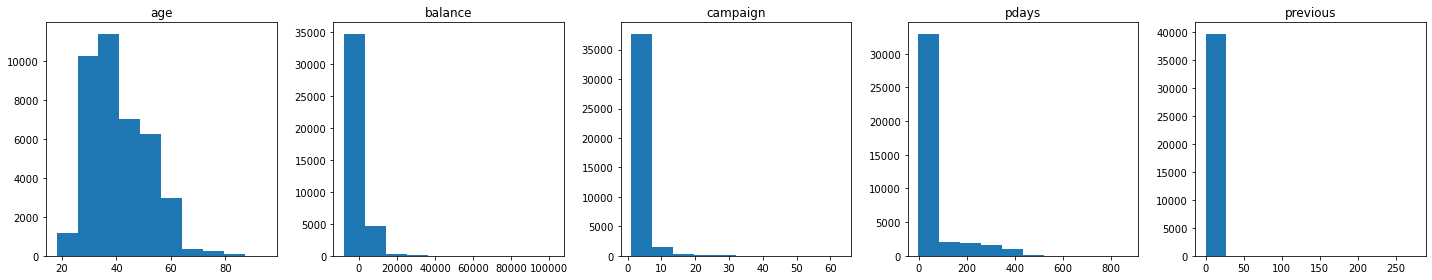

In [340]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20,4))
for index, col in enumerate(X_train_continuous):
    axes[index].hist(X_train_continuous[col])
    axes[index].set_title(X_train_continuous.columns[index])
plt.tight_layout();

Each of these distributions skew left. It turns out that [continuous features do not need to be normally distributed in a decision tree classification problem](https://www.sciencedirect.com/topics/nursing-and-health-professions/logistic-regression-analysis#:~:text=Logistic%20regression%20does%20not%20assume,equal%20variance%20within%20each%20group), but I should normalize them for the StatsModels and Scikit-Learn Logit models. 

Also, it's worth noting that all these attributes except for 'age' start on zero and all of them contain a few high outliers. 

Before I examine the categorical columns, the date information is kind of in a grey area. Let's check out how the months look:

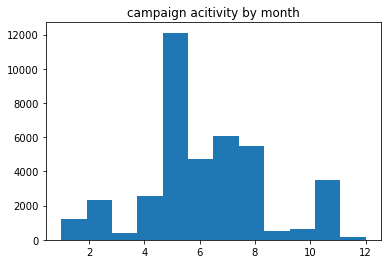

In [341]:
fig, ax = plt.subplots()
ax.hist(X_train['month'], bins=12)
ax.set_title('campaign acitivity by month');

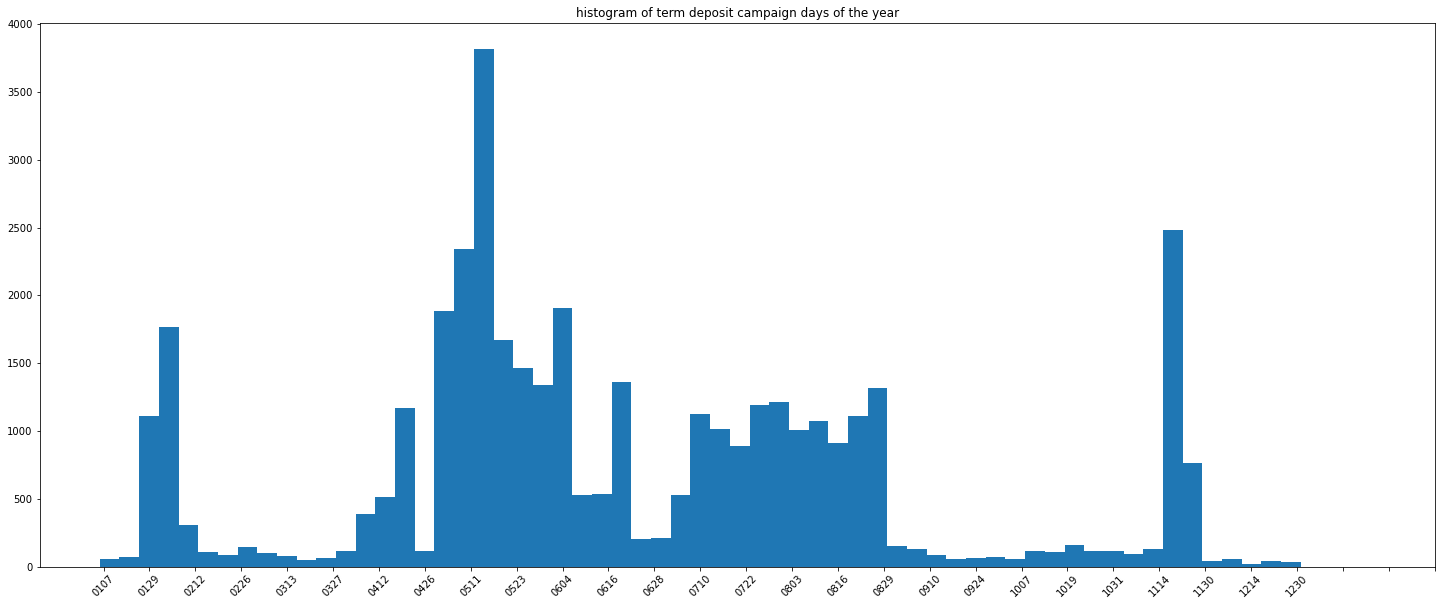

In [342]:
#Have to do a little legwork to resort the 'month-day' column for a histogram
X_train_month_day_sorted = X_train['month-day'].copy()
X_train_month_day_sorted.sort_values(inplace=True)
#Plotting the histogram
x_ticks_range = np.arange(1, 360, 12)
fig, ax = plt.subplots(figsize=(25,10))
ax.hist(X_train_month_day_sorted, bins='auto')
ax.set_title('histogram of term deposit campaign days of the year')
plt.xticks(x_ticks_range, rotation=45);

This is just the months/days of the year for the records in our dataset; not the successful conversion attempt days. Nonetheless, we can see they were a lot more active during the summer with a few spikes along the way in late-January/early-February, April, and then a pretty big one during November.

### Now let's see how the other categorical columns look. 

This graph may be a little hard to read in detail, but for now, I'm just looking to see the general distribution of each column, not the details.

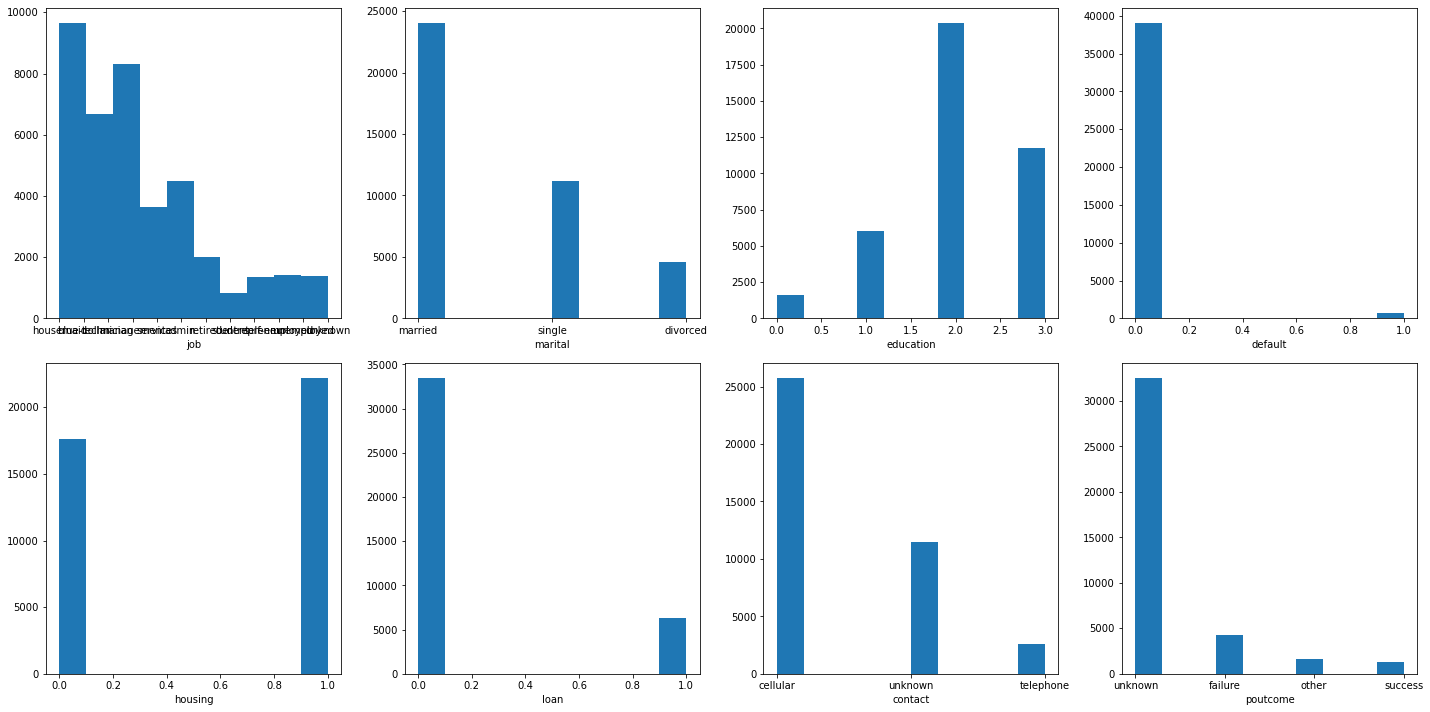

In [343]:
X_train_categorical = X_train[['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
for i, column in enumerate(X_train_categorical.columns):
    row = i//4
    col = i%4
    ax = axes[row][col]
#    ax.hist(column, density=True)
#    ax.hist(column, bins='auto')
    ax.hist(X_train[column])
    ax.set_xlabel(column)
plt.tight_layout();

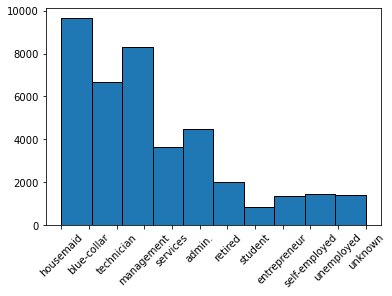

In [344]:
#The first one ('job') is hard to see, here it is on its own.
plt.hist(X_train['job'], edgecolor='black')
plt.xticks(rotation=45);

So, when it comes to issue of entropy, it looks like the 'default' and 'loan' columns would make the best case for earlier splits in a decision tree, with 'poutcome' next, then probably 'marital', 'contact', and 'education' won't be too far behind, then 'job' and 'housing' round out the end of the line. Of course, we won't know until we run a decision tree model. 

## establishing a baseline model

Statistical significance still matters in logistic regression. It seems like the most effective way to check our data for it is to fit a StatsModels Logit model to it and see how it measures up. I'm not necessarily going to make a Logit model the baseline, but I think I should at least *start* here.

First, let's one-hot encode the X_train's categorical columns.

In [345]:
#one-hot encoding the categorical columns
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
#X_train_categorical_ohe = X_train_categorical
#codes = ohe.fit_transform(X_train_categorical_ohe)
columns_to_ohe = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
encoded = ohe.fit_transform(X_train[columns_to_ohe])
encoded

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [346]:
X_train_categorical_ohe = pd.DataFrame(encoded,
                                      columns=ohe.get_feature_names_out(),
                                      index=X_train.index)
X_train_preprocessed = pd.concat([X_train, X_train_categorical_ohe], axis=1).drop(columns_to_ohe, axis=1)
X_train_preprocessed

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,education_2,education_3,default_1,housing_1,loan_1,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
22065,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23946,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14232,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
15211,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47464,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
46755,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
18813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


### normalizing features for Logit models

X_train_preprocessed is ready for a decision tree model, but not for the StatsModels & Scikit-Learn Logit models because its continuous features have not yet been normalized. Let's create a X_train_preprocessed_normalized for them.

In [348]:
columns_to_normalize = ['age', 'balance', 'campaign', 'pdays', 'previous']
#importing, instantiating, and fitting MinMaxScaler to X_train's continuous columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_preprocessed_normalized_columns = scaler.fit_transform(X_train[columns_to_normalize])
X_train_preprocessed_normalized_columns

array([[0.42857143, 0.10445227, 0.16129032, 0.        , 0.        ],
       [0.46753247, 0.07703412, 0.0483871 , 0.        , 0.        ],
       [0.22077922, 0.08448786, 0.01612903, 0.        , 0.        ],
       ...,
       [0.22077922, 0.08279011, 0.01612903, 0.        , 0.        ],
       [0.41558442, 0.08313511, 0.11290323, 0.        , 0.        ],
       [0.18181818, 0.08617653, 0.09677419, 0.        , 0.        ]])

In [349]:
#new column names for normalized columns so I can drop their non-normalized counterparts
normalized_column_names = ['age_normalized', 'balance_normalized', 
                           'campaign_normalized', 'pdays_normalized', 'previous_normalized']
#Turning it back into a DataFrame
X_train_preprocessed_normalized_df = pd.DataFrame(X_train_preprocessed_normalized_columns,
                                      columns=normalized_column_names,
                                      index=X_train.index)
X_train_preprocessed_normalized = pd.concat([X_train_preprocessed_normalized_df, 
                                             X_train_preprocessed], axis=1).drop(columns_to_normalize, axis=1)
X_train_preprocessed_normalized

,age_normalized,balance_normalized,campaign_normalized,pdays_normalized,previous_normalized,day,month,duration,month-day,job_blue-collar,...,education_2,education_3,default_1,housing_1,loan_1,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
22065,0.428571,0.104452,0.161290,0.000000,0.000000,20,8,135,0820,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
23946,0.467532,0.077034,0.048387,0.000000,0.000000,29,8,436,0829,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14232,0.220779,0.084488,0.016129,0.000000,0.000000,14,7,330,0714,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
15211,0.415584,0.072976,0.048387,0.000000,0.000000,17,7,209,0717,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24198,0.207792,0.073757,0.000000,0.225917,0.007273,17,11,303,1117,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47464,0.155844,0.090271,0.000000,0.000000,0.000000,6,2,170,0206,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2114,0.467532,0.069744,0.016129,0.000000,0.000000,12,5,288,0512,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
46755,0.220779,0.082790,0.016129,0.000000,0.000000,29,1,127,0129,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
18813,0.415584,0.083135,0.112903,0.000000,0.000000,31,7,73,0731,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [268]:
#I had to cast X_train_preprocessed as ints at one point for StatsModels' Logit, but 
# just remember, this can't be done to X_train_preprocessed_normalized.

X_train_preprocessed = X_train_preprocessed.astype(int)
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39785 entries, 22065 to 21197
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                39785 non-null  int32
 1   balance            39785 non-null  int32
 2   day                39785 non-null  int32
 3   month              39785 non-null  int32
 4   duration           39785 non-null  int32
 5   campaign           39785 non-null  int32
 6   pdays              39785 non-null  int32
 7   previous           39785 non-null  int32
 8   month-day          39785 non-null  int32
 9   job_blue-collar    39785 non-null  int32
 10  job_entrepreneur   39785 non-null  int32
 11  job_housemaid      39785 non-null  int32
 12  job_management     39785 non-null  int32
 13  job_retired        39785 non-null  int32
 14  job_self-employed  39785 non-null  int32
 15  job_services       39785 non-null  int32
 16  job_student        39785 non-null  int32
 17  job_tech

In [238]:
y_train

22065    0
23946    0
14232    0
15211    0
24198    0
        ..
47464    0
2114     0
46755    0
18813    0
21197    0
Name: y, Length: 39785, dtype: int64

### Trying StatsModels' Logit on non-normalized continuous features first

In [243]:
import statsmodels.api as sm
#adding the constant to X_train_ohe
X = sm.add_constant(X_train_preprocessed)
#y = np.asarray(y_train)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
result = logit_model.fit(maxiter=1000)
#checking the results
result.summary()

Optimization terminated successfully.
         Current function value: 0.250569
         Iterations 735


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                39785
Model:                          Logit   Df Residuals:                    39751
Method:                           MLE   Df Model:                           33
Date:                Wed, 27 Dec 2023   Pseudo R-squ.:                  0.3048
Time:                        17:23:05   Log-Likelihood:                -9968.9
converged:                       True   LL-Null:                       -14339.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.1116      0.196    -10.784      0.000      -2.495      -1.728
age               -5.359e-07      0.002     -0.000      1.000      -0.004       0.004
balance            1.898e-05   5.04e-06      3.769      0.000    9.11e-06    2.88e-05
day                  -0.0054        nan        nan        nan         nan         nan
month                 0.0003        nan        nan        nan         nan         nan
duration              0.0041   6.68e-05     60.832      0.000       0.004       0.004
campaign             -0.1038      0.010     -9.926      0.000      -0.124      -0.083
pdays                 0.0003      0.000      0.927      0.354      -0.000       0.001
previous              0.0066      0.006      1.075      0.282      -0.005       0.019
month-day            -0.0002        nan        nan        nan         nan         nan
job_blue-collar      -0.3756      0.075     -5.003      0.000      -0.523      -0.228
job_entrepreneur     -0.5923      0.132     -4.481      0.000      -0.851      -0.333
job_housemaid        -0.5138      0.138     -3.720      0.000      -0.784      -0.243
job_management       -0.3119      0.076     -4.082      0.000      -0.462      -0.162
job_retired           0.3383      0.099      3.403      0.001       0.143       0.533
job_self-employed    -0.3511      0.113     -3.096      0.002      -0.573      -0.129
job_services         -0.3038      0.087     -3.480      0.001      -0.475      -0.133
job_student           0.4215      0.113      3.734      0.000       0.200       0.643
job_technician       -0.3336      0.072     -4.647      0.000      -0.474      -0.193
job_unemployed       -0.3555      0.120     -2.968      0.003      -0.590      -0.121
job_unknown          -0.2035      0.227     -0.897      0.370      -0.648       0.241
marital_married      -0.1853      0.061     -3.043      0.002      -0.305      -0.066
marital_single        0.0986      0.070      1.418      0.156      -0.038       0.235
education_1          -0.2116      0.108     -1.951      0.051      -0.424       0.001
education_2          -0.0346      0.096     -0.362      0.717      -0.222       0.153
education_3           0.2394      0.100      2.386      0.017       0.043       0.436
default_1            -0.0750      0.166     -0.452      0.651      -0.400       0.250
housing_1            -0.7721      0.042    -18.286      0.000      -0.855      -0.689
loan_1               -0.6046      0.063     -9.641      0.000      -0.727      -0.482
contact_telephone    -0.0618      0.076     -0.811      0.418      -0.211       0.088
contact_unknown      -1.1988      0.062    -19.387      0.000      -1.320      -1.078
poutcome_other        0.2437      0.092      2.654      0.008       0.064       0.424
poutcome_success      2.2975      0.085     27.019      0.000       2.131       2.464
poutcome_unknown     -0.1915      0.096     -1.991      0.046      -0.380      -0.003
===========================================================

Overall, this model has a good p-value, but some of the features don't:

- 'age'
- 'pdays'
- 'previous'
- 'job_unknown'
- 'marital_single'
- 'education_1' & 'education_2'
- 'default_1'
- 'contact_telephone'

Does the model improve when we get rid of them? I don't know, let's run some metrics first.

In [258]:
result.fittedvalues

22065   -3.972731
23946   -1.815223
14232   -2.696313
15211   -2.664260
24198   -2.211926
           ...   
47464   -2.193180
2114    -3.645265
46755   -3.012824
18813   -4.689756
21197   -2.420074
Length: 39785, dtype: float64

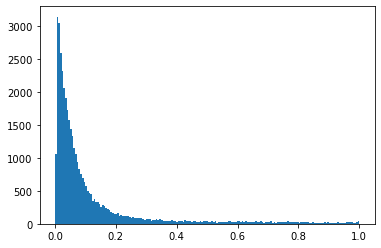

In [260]:
proba = 1 / (1 + np.exp( - result.fittedvalues ))
plt.hist(proba, bins='auto');

In [265]:
print(y_test.shape)
print(X_test_preprocessed.shape)
print(X_train_preprocessed.shape)

(9947,)
(9947, 33)
(39785, 33)


In [279]:
y_test.value_counts(normalize=True)

0    0.882879
1    0.117121
Name: y, dtype: float64

In [269]:
X_test_preprocessed = X_test_preprocessed.astype(int)
X_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9947 entries, 28303 to 15966
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                9947 non-null   int32
 1   balance            9947 non-null   int32
 2   day                9947 non-null   int32
 3   month              9947 non-null   int32
 4   duration           9947 non-null   int32
 5   campaign           9947 non-null   int32
 6   pdays              9947 non-null   int32
 7   previous           9947 non-null   int32
 8   month-day          9947 non-null   int32
 9   job_blue-collar    9947 non-null   int32
 10  job_entrepreneur   9947 non-null   int32
 11  job_housemaid      9947 non-null   int32
 12  job_management     9947 non-null   int32
 13  job_retired        9947 non-null   int32
 14  job_self-employed  9947 non-null   int32
 15  job_services       9947 non-null   int32
 16  job_student        9947 non-null   int32
 17  job_techn

In [276]:
#making predictions
X_test_for_pred = sm.add_constant(X_test_preprocessed)
y_pred_test = round(result.predict(X_test_for_pred), 0).astype(int)
y_pred_test

28303    0
14645    1
24964    0
44226    1
3665     0
        ..
23972    0
31008    0
29381    0
14279    0
15966    0
Length: 9947, dtype: int32

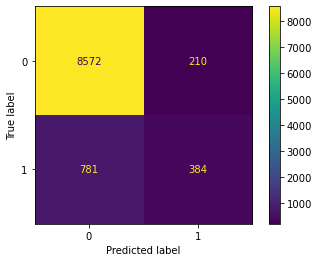

In [277]:
#importing & building a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

This reminds me, we need to address the class-imbalance problem. Before we get into that, let's break down this confusion matrix, which shows the model's predictions out from 9,947 test records. Ideally, we'd have all true predictions and 88% would be negative and 11% would be positive: 

- predicted true positives (bottom right) 384 times (3.9% of all predictions)
- predicted false positives (top right) 210 times (2.1%)
- predicted true negatives (top left) 8,572 times (86.2%)
- predicted false negatives (bottom left) 781 times (7.9%)

Overall, these results look good, but there are a few columns with unacceptable p-values. This won't matter for a decision tree model, but it may very well be a big deal for our Logit model later on.

Should I run some evaluation metrics here now? Are there hyperparams or other things to do to refine this StatsModels model?

In [284]:
print('recall score:', recall_score(y_test, y_pred_test))

recall score: 0.3296137339055794


Oof, not great. What about AUC?

In [281]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('test AUC:', auc(fpr, tpr))

test AUC: 0.6528505927555681


Kind of meh. What about the log loss cross val score?

In [288]:
baseline_neg_log_loss_cv_test = cross_val_score(result, X_test_preprocessed, y_test, scoring='neg_log_loss')
baseline_log_loss_test = -(baseline_neg_log_loss_cv_test.mean())
print('testing log loss score:', baseline_log_loss_test)

TypeError: Cannot clone object '<statsmodels.discrete.discrete_model.Logit object at 0x0000019414306F70>' (type <class 'statsmodels.discrete.discrete_model.Logit'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

Okay that's only for scikit-learn stuff. Okay, now let's try statsmodels logit with normalized data:

In [352]:
#adding the constant to X_train
X = sm.add_constant(X_train_preprocessed_normalized)
#y = np.asarray(y_train)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
result = logit_model.fit(maxiter=3500)
#checking the results
result.summary()

Optimization terminated successfully.
         Current function value: 0.250569
         Iterations 3389


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                39785
Model:                          Logit   Df Residuals:                    39751
Method:                           MLE   Df Model:                           33
Date:                Thu, 28 Dec 2023   Pseudo R-squ.:                  0.3048
Time:                        17:11:12   Log-Likelihood:                -9968.9
converged:                       True   LL-Null:                       -14339.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.3680      0.180    -13.141      0.000      -2.721      -2.015
age_normalized      -4.127e-05      0.176     -0.000      1.000      -0.346       0.346
balance_normalized      2.0905      0.555      3.769      0.000       1.003       3.178
campaign_normalized    -6.4386      0.649     -9.926      0.000      -7.710      -5.167
pdays_normalized        0.2586      0.279      0.927      0.354      -0.288       0.806
previous_normalized     1.8241      1.697      1.075      0.282      -1.503       5.151
day                    -0.0054        nan        nan        nan         nan         nan
month                   0.0009        nan        nan        nan         nan         nan
duration                0.0041   6.68e-05     60.832      0.000       0.004       0.004
month-day              -0.0002        nan        nan        nan         nan         nan
job_blue-collar        -0.3756      0.075     -5.003      0.000      -0.523      -0.228
job_entrepreneur       -0.5923      0.132     -4.481      0.000      -0.851      -0.333
job_housemaid          -0.5138      0.138     -3.720      0.000      -0.784      -0.243
job_management         -0.3119      0.076     -4.082      0.000      -0.462      -0.162
job_retired             0.3383      0.099      3.403      0.001       0.143       0.533
job_self-employed      -0.3511      0.113     -3.096      0.002      -0.573      -0.129
job_services           -0.3038      0.087     -3.480      0.001      -0.475      -0.133
job_student             0.4215      0.113      3.734      0.000       0.200       0.643
job_technician         -0.3336      0.072     -4.647      0.000      -0.474      -0.193
job_unemployed         -0.3555      0.120     -2.968      0.003      -0.590      -0.121
job_unknown            -0.2035      0.227     -0.897      0.370      -0.648       0.241
marital_married        -0.1853      0.061     -3.043      0.002      -0.305      -0.066
marital_single          0.0986      0.070      1.418      0.156      -0.038       0.235
education_1            -0.2116      0.108     -1.951      0.051      -0.424       0.001
education_2            -0.0346      0.096     -0.362      0.717      -0.222       0.153
education_3             0.2394      0.100      2.386      0.017       0.043       0.436
default_1              -0.0750      0.166     -0.452      0.651      -0.400       0.250
housing_1              -0.7721      0.042    -18.286      0.000      -0.855      -0.689
loan_1                 -0.6046      0.063     -9.641      0.000      -0.727      -0.482
contact_telephone      -0.0618      0.076     -0.811      0.418      -0.211       0.088
contact_unknown        -1.1988      0.062    -19.387      0.000      -1.320      -1.078
poutcome_other          0.2437      0.092      2.654      0.008       0.064       0.424
poutcome_success        2.2975      0.085     27.019      0.000       2.131       2.464
poutcome_unknown       -0.1915      0.096     -1.991      0.046      -0.3

Okay, feeding StatsModel's Logit normalized continuous data changed absolutely nothing, so no need to rerun evaluation metrics. Now let's drop the bad columns and see whether that helps:

In [354]:
columns_to_drop = ['age_normalized', 'pdays_normalized', 'previous_normalized', 'job_unknown', 'marital_single', 
                   'education_1', 'education_2', 'default_1', 'contact_telephone']
X_train_preprocessed_normalized_with_acceptable_pvals = X_train_preprocessed_normalized.drop(columns_to_drop, axis=1)

In [355]:
#adding the constant to X_train
X = sm.add_constant(X_train_preprocessed_normalized_with_acceptable_pvals)
#y = np.asarray(y_train)
#instantiating & fitting the Logit model
logit_model = sm.Logit(y_train.astype(float), X.astype(float))
result = logit_model.fit(maxiter=3500)
#checking the results
result.summary()

Optimization terminated successfully.
         Current function value: 0.250746
         Iterations 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                39785
Model:                          Logit   Df Residuals:                    39760
Method:                           MLE   Df Model:                           24
Date:                Thu, 28 Dec 2023   Pseudo R-squ.:                  0.3043
Time:                        17:18:43   Log-Likelihood:                -9975.9
converged:                       True   LL-Null:                       -14339.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.2572      0.104    -21.785      0.000      -2.460      -2.054
balance_normalized      2.0862      0.552      3.778      0.000       1.004       3.168
campaign_normalized    -6.5025      0.648    -10.040      0.000      -7.772      -5.233
day                    -0.0055    820.204  -6.67e-06      1.000   -1607.575    1607.564
month                3.085e-05    8.2e+04   3.76e-10      1.000   -1.61e+05    1.61e+05
duration                0.0041   6.67e-05     60.871      0.000       0.004       0.004
month-day              -0.0002    820.204  -1.96e-07      1.000   -1607.570    1607.569
job_blue-collar        -0.4141      0.071     -5.795      0.000      -0.554      -0.274
job_entrepreneur       -0.6087      0.131     -4.647      0.000      -0.865      -0.352
job_housemaid          -0.5902      0.134     -4.392      0.000      -0.854      -0.327
job_management         -0.3145      0.075     -4.216      0.000      -0.461      -0.168
job_retired             0.2751      0.085      3.224      0.001       0.108       0.442
job_self-employed      -0.3540      0.112     -3.154      0.002      -0.574      -0.134
job_services           -0.2965      0.086     -3.437      0.001      -0.466      -0.127
job_student             0.4545      0.108      4.217      0.000       0.243       0.666
job_technician         -0.3192      0.070     -4.530      0.000      -0.457      -0.181
job_unemployed         -0.3742      0.118     -3.160      0.002      -0.606      -0.142
marital_married        -0.2621      0.039     -6.672      0.000      -0.339      -0.185
education_3             0.3007      0.052      5.825      0.000       0.199       0.402
housing_1              -0.7633      0.041    -18.478      0.000      -0.844      -0.682
loan_1                 -0.6039      0.062     -9.676      0.000      -0.726      -0.482
contact_unknown        -1.1997      0.061    -19.520      0.000      -1.320      -1.079
poutcome_other          0.2413      0.091      2.641      0.008       0.062       0.420
poutcome_success        2.2827      0.082     27.779      0.000       2.122       2.444
poutcome_unknown       -0.2820      0.058     -4.846      0.000      -0.396      -0.168
=======================================================================================
"""

No real difference here, so nevermind. Okay, [there are no hyperparams for SM Logit for weighing classes](https://stackoverflow.com/questions/33605979/statsmodels-logistic-regression-class-imbalance), but maybe I can feed it the under/over sampled training data from the decision tree models.

**Wait, first I have to revise the X_train_ohe stuff to be correct like I did above.**

### building a decision tree model

I think a decision tree is the best way to go right now and then, if we want to "exceed objectives" later, we can try a scikit-learn or StatsModels classification model later. But ultimately, I don't how else I'd find out which attributes correlate best outside of a decision tree. 

I know decision trees are all about how you set them up, pruning, and hyperparameters. To that end, maybe our "baseline" here is a "vanilla" model where we don't do any of that stuff first.

In [244]:
#Importing everything we'll need for our baseline model
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [251]:
#instantiating & fitting the DecisionTreeClassifier model
clf_baseline = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_baseline.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=713)

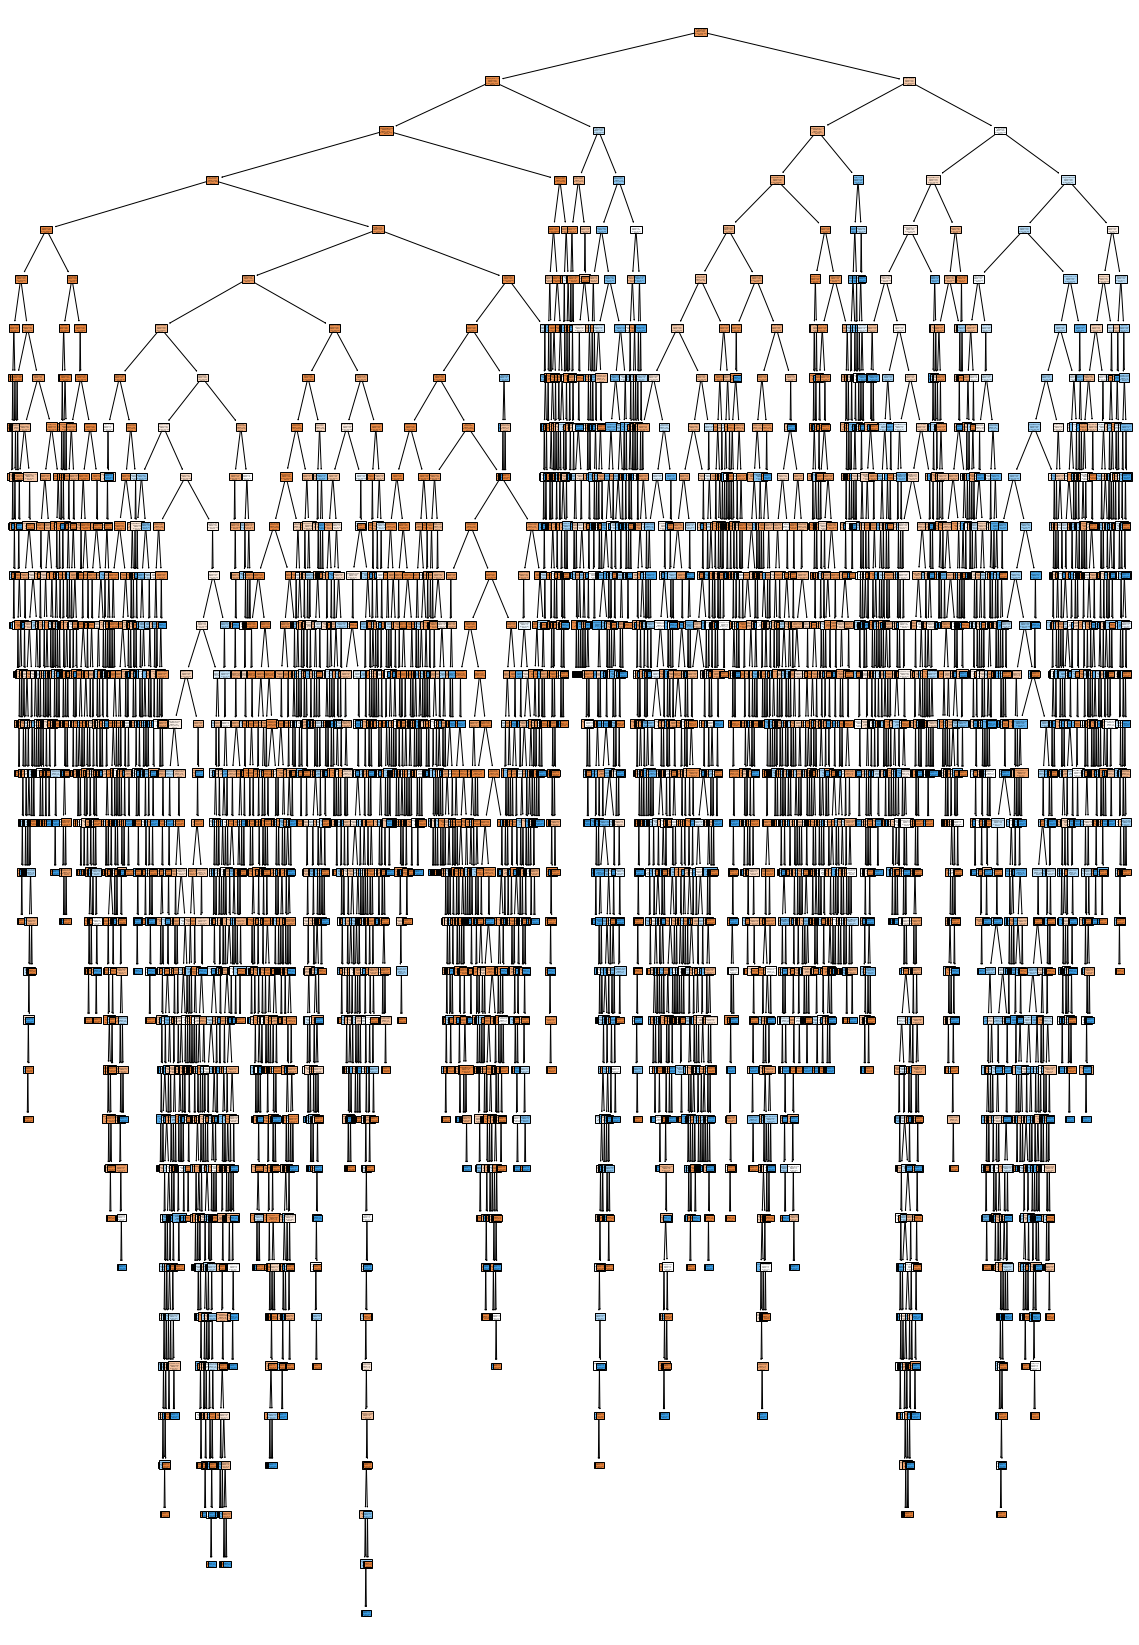

In [253]:
#Checking out the tree plot
fig, ax = plt.subplots(figsize=(20,30))
tree.plot_tree(clf_baseline,
              feature_names = X_train_preprocessed.columns,
              class_names = np.unique(y).astype('str'),
              filled=True)
plt.show();

In [25]:
#Wow, what a monstrosity. We'll definitely need to prune this tree. 

#Let's evaluate with accuracy for now, just to see and get a feel for what's going on:
#X_test_ohe = ohe.transform(X_test)
#y_pred_test = clf.predict(X_test_ohe)
#print('accuracy:', accuracy_score(y_test, y_pred_test))

#WAIT, I'm not supposed to use accuracy, let's see if we can pin down whether we want 
# to priveledge precision, recall, or both (in which case, we'd employ an F1 score.)

### Evaluating the baseline model

Okay, so next is (1) evaluation metrics (ConfusionMatrices, AUC/ROC, class imbalance, more in my notes) and (2) tree-pruning. I guess the iterative pruning of hyperparameters would take a long time, but it's still feasible.

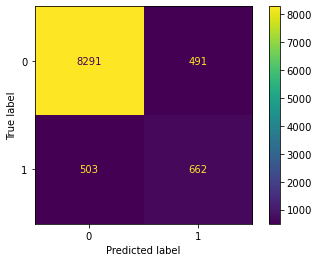

In [362]:
#tranforming X_test with OneHotEncoder 
encoded = ohe.transform(X_test[columns_to_ohe])
X_test_categorical_ohe = pd.DataFrame(encoded,
                                      columns=ohe.get_feature_names_out(),
                                      index=X_test.index)
X_test_preprocessed = pd.concat([X_test, X_test_categorical_ohe], axis=1).drop(columns_to_ohe, axis=1)

#making our y_test predictions
y_pred_test = clf_baseline.predict(X_test_preprocessed)

#confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test); #8851 / 9947

Let's break down this confusion matrix, which shows the model's predictions out from 9,947 test records:

- predicted true positives (bottom right) 662 times (6.7% of all predictions)
- predicted false positives (top right) 491 times (5%)
- predicted true negatives (top left) 8,291 times (83.4%)
- predicted false negatives (bottom left) 503 times (5.1%)

So, this model is dealing with just a little bit more in the way of false negatives than false positives. **Which is a bigger deal for our stakeholder? Probably false negatives** because they represent current clients who would have made a term deposit, but weren't on the call list given to the hired call center.

False positives probably aren't as big a deal; sure, it's not ideal to have paid the call center to contact those clients who didn't wind up setting an account, but the "wasted" cost for those client calls was likely less than the profit they lose from false positives. All this to say, we want to priveldge **recall** as an evaluation metric here. 

In [363]:
#First I need to make my training set predictions
y_pred_train = clf_baseline.predict(X_train_preprocessed)
#Now we can proceed with the recall_score
from sklearn.metrics import recall_score
print('train recall:', recall_score(y_train, y_pred_train))
print('test recall:', recall_score(y_test, y_pred_test))

train recall: 1.0
test recall: 0.5682403433476395


In [364]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_test)

0.5711820534943919

That is some serious overfitting and a just okay test recall score. Hopefully our refined models make substantial improvements. Honestly, it wouldn't take *too* much to improve on that, so I wonder whether this vanilla model can even serve as a meaningful baseline. We shall see. For now, let's keep evaluating it and check out the ROC/AUC metric.

In [365]:
#Now we're ready to check the area under curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
print('train AUC:', auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('test AUC:', auc(fpr, tpr))

train AUC: 1.0
test AUC: 0.7561652639079349


This is just an okay test AUC score; it's definitely better than random guessing, but not by an impressive amount. Again, hopefully pruning our decision tree model and accounting for class imbalance will result in a significant improvement.

In [356]:
#Now we'll do a cross validation score with negative log loss because...we did it in earlier lessons.
from sklearn.model_selection import cross_val_score
#train
baseline_neg_log_loss_cv_train = cross_val_score(clf_baseline, X_train_preprocessed, y_train, scoring='neg_log_loss')
baseline_log_loss_train= -(baseline_neg_log_loss_cv_train.mean())
print('training log loss score:', baseline_log_loss_train)
#test
baseline_neg_log_loss_cv_test = cross_val_score(clf_baseline, X_test_preprocessed, y_test, scoring='neg_log_loss')
baseline_log_loss_test = -(baseline_neg_log_loss_cv_test.mean())
print('testing log loss score:', baseline_log_loss_test)

training log loss score: 3.9110330949055863
testing log loss score: 4.246860664610051


This is not as interpetable as the other metrics yet, but it will be once we start refining and reevaluating later models. 

### Next steps 

Class imbalance and tree pruning on this model. Afterwards, it's trying the whole thing again with a LogisticRegression model. 

## Addressing target class imbalance

We've learned about the class_weight hyperparameter, but that's for LogisticRegression models, so we'll run that later when we do a second model attempt. Actually, when you finish with the decision tree stuff and do LogisticRegression, go to the Logistic Regression - Cumulative Lab from Topic 26 and do that stuff. 

I'm realizing that class imbalance in decision trees hasn't been discussed yet, just in LogisticRegression. Nonetheless, there *is* a class_weight param for the DecisionTreeCladsifier model, too. What I still don't understand is how to apply the over & under-sampling by percentage technique that Mark discussed to a decision tree.

In [357]:
clf_balanced_class = DecisionTreeClassifier(criterion='entropy', random_state=713, class_weight="balanced")
clf_balanced_class.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=713)

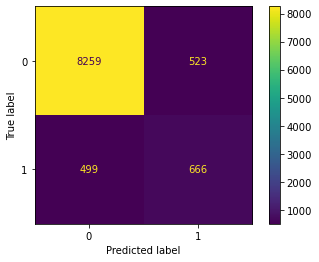

In [366]:
y_pred_test = clf_balanced_class.predict(X_test_preprocessed)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

The class_weight = 'balanced' model:

- predicted true positives (bottom right) 666 times (6.7% of all predictions, the baseline was also at 6.7%)
- predicted false positives (top right) 523 times (5.3%, baseline was 5.0%)
- predicted true negatives (top left) 8,259 times (83.0%, baseline was 83.4%)
- predicted false negatives (bottom left) 499 times (5.0%, baseline was 5.1%)

So, this model predicted four more true positives than the baseline, but 32 more false ones. Of course, that means it wasn't quite as good at predicting true negatives, but it was slightly better at false negatives. This is a mixed bag improvement-wise, but it does bode well for an improvement in the recall score, which we are more concerned with in this case. Let's check to be sure:

In [367]:
print('recall:', recall_score(y_test, y_pred_test))

recall: 0.5716738197424893


I think this is a decent, but still somewhat modest improvement over the baseline score of 0.568. Let's keep checking evaluation metrics and do the AUC: 

In [368]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('AUC:', auc(fpr, tpr))

AUC: 0.7560600936562595


This is a slight reduction compared to the baseline's 0.75617. There's definitely more to improve upon here, but we're on our way. Let's finally check the cross-validated loss score:

In [369]:
balanced_class_neg_log_loss_cv = cross_val_score(clf_balanced_class, X_test_preprocessed, y_test, scoring='neg_log_loss')
balanced_class_log_loss = -(balanced_class_neg_log_loss_cv.mean())
balanced_class_log_loss

4.228706387089582

This is a slight improvement over the baseline's 4.246860664610051 score. 

### Further improvement of the class imbalance problem

So far, we found some modest improvement with the 'balanced' class_weight parameter, but I still need to further tweak it. I'm not sure how, though. Can I use SMOTE here? [The docs also mention a dictionary of class weights to run](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), do I run different dictionaries with SMOTE like we did in that one cumulative lab? 

In [370]:
import imblearn
print(imblearn.__version__)

0.11.0


Oversampling and undersampling has not yet been covered in the curriciulum outside of SMOTE, so I found a helpful resourcse [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) and am going to practice a bit below using some of the code snippets from that site.

In [371]:
y_train.value_counts()

0    35140
1     4645
Name: y, dtype: int64

Ok, so we have what we expect here, 80% of the total 49k dataset records in X & y train. We also see how y_train has a 87/13% no/yes split. 

Now we're going to see what happens when we use and play around with imblearn's RandomOverSampler tool:

In [372]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_train_preprocessed_over, y_train_over = oversample.fit_resample(X_train_preprocessed, y_train)
#How does y_over look now?
y_train_over.value_counts()

0    35140
1    35140
Name: y, dtype: int64

In [373]:
len(y_train)/len(y_train_over)

0.5660927717700626

Ok, y_over is not only completely balanced, but also a *lot* bigger than it used to be. What's X_train like?

In [374]:
len(X_train_preprocessed_over)

70280

In [375]:
len(X_train_preprocessed)/len(X_train_preprocessed_over)

0.5660927717700626

Wow, this oversampled X_train is a lot bigger (and by the same amount as y_over is than y_train). So, X_over & y_over are a synthetic training dataset that may or may not result in better results. If I had to guess, I'd bet the training scores will still be way overfit and the test scores will because we oversampled too much here at the outset, but let's see. 

In [376]:
#fit the model to X_over & y_over
clf_oversample_minority = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_oversample_minority.fit(X_train_preprocessed_over, y_train_over)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [377]:
#make predictions for our evaluation metrics
#Remember, we can't do any oversampling with the test set
y_pred_test_over = clf_oversample_minority.predict(X_test_preprocessed)

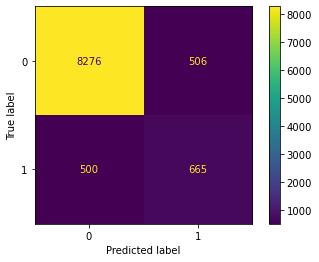

In [378]:
#confusion matrix for this new oversampling model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over);

The oversampling with RandomOverSampler(sampling_strategy='minority') model:

- predicted true positives (bottom right) 665 times (6.7% of all predictions, the baseline had 6.7%)
- predicted false positives (top right) 506 times (5.1%, baseline was 5.0%)
- predicted true negatives (top left) 8,276 times (83.2%, baseline was 83.4%)
- predicted false negatives (bottom left) 500 times (5.0%, baseline was 5.1%)

To review, our last model (class_weight = 'balanced') showed the following results:

- predicted true positives 666 times (6.7%)
- predicted false positives 523 times (5.3%)
- predicted true negatives 8,259 times (83.0%)
- predicted false negatives 499 times (5.0%)

So that means both newer models are similar and slightly better than the baseline recall-wise, but the earlier class_weight = 'balanced' was better than this latest one. However, I wonder to what extent RandomOverSampler(sampling_strategy='minority') introduced noise into the training data; the resulting X_train_preprocessed_over and y_train_over datasets were a lot larger.

Subsequently, we can try oversampling to more subtle degrees and see whether our models improve. Before doing that, let's keep looking at our ohter metrics to see how this latest model performed.

In [379]:
#recall scores
#We can't do a train score here because y_train and y_train_over are different sizes
print('recall:', recall_score(y_test, y_pred_test_over))

recall: 0.5708154506437768


Like with our confusion matrix results, this is an improvement over the baseline score of 0.56824, but not as good as the class_weight = 'balanced' model's 0.5717.

In [380]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
print("oversampling = 'minority' AUC:", auc(fpr, tpr))

oversampling = 'minority' AUC: 0.7565987979704878


This is a really slight improvement over the baseline's 0.7562 as well as the class_weight = 'balanced' model's AUC of 0.7561.

### Iterating through more subtle oversampling parameters

I know that the maximum we should really try to oversample to is half the size of the classes, so let's try iterating through several more subtle sample_strategy params and see whether we can find a better result along the way. I'm only supposed to go as high as 150%, so the following dictionaries for our next iteration attempt will reflect 150% oversampling down to 110%, moving in 10% increments (so 150%, 140%, 130%, 120%, and 110%):

In [383]:
sampling_strategies = [{0:35140, 1:6968}, {0:35140, 1:6503}, {0:35140, 1:6039}, {0:35140, 1:5574}, {0:35140, 1:5156}]

In [399]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define oversampling strategy
    oversample = RandomOverSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_preprocessed_over, y_train_over = oversample.fit_resample(X_train_preprocessed, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_oversample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_oversample_float.fit(X_train_preprocessed_over, y_train_over)
    #make predictions for our evaluation metrics
    y_pred_test_over = clf_oversample_float.predict(X_test_preprocessed)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_over))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 1.5 through 1.1 sample_strategy dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 1.5 through 1.1 sample_strategy dictionaries:
recall scores: [0.5587982832618026, 0.5896995708154507, 0.5665236051502146, 0.582832618025751, 0.5802575107296137]
auc_scores:    [0.7521843841724636, 0.7675211586712188, 0.7553068948092224, 0.7651694404180224, 0.7616614358476126]


In [400]:
print('maximum recall score:', max(recall_scores))
print('maximum AUC score:', max(auc_scores))

maximum recall score: 0.5896995708154507
maximum AUC score: 0.7675211586712188


When we oversample the minority class in our target ("yes", aka "1") by 140%, we achieve the best recall score among these, which is also the best we've seen so far. The highest AUC score also appears at this oversampling rate. Let's position the 140% oversampling model as our best so far and check the other evaluation metrics:

In [402]:
#Set oversampling to 140%
oversample = RandomOverSampler(random_state=713, sampling_strategy={0:35140, 1:6503})
# fit and apply the transform
X_train_preprocessed_over, y_train_over = oversample.fit_resample(X_train_preprocessed, y_train)    
#instantiate & fit the model to X_over & y_over
clf_oversample_140 = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_oversample_140.fit(X_train_preprocessed_over, y_train_over)

#make predictions for our evaluation metrics
y_pred_test_over = clf_oversample_140.predict(X_test_preprocessed)

#confirming recall score
print('recall score when oversampling at 140%:', recall_score(y_test, y_pred_test_over))
#calculate auc score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_over)
print('AUC score when oversampling at 140%', auc(fpr, tpr))

recall score when oversampling at 140%: 0.5896995708154507
AUC score when oversampling at 140% 0.7675211586712188


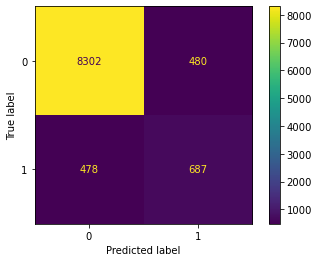

In [403]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_over);

The oversampling at 140% model:

- predicted true positives (bottom right) 687 times (6.9% of all predictions, the baseline had 6.7%)
- predicted false positives (top right) 480 times (4.8%, baseline was 5.0%)
- predicted true negatives (top left) 8,302 times (83.5%, baseline was 83.4%)
- predicted false negatives (bottom left) 478 times (4.8%, baseline was 5.1%)

Definitely the best we've done so far.

### Undersampling and then SMOTE

Time to move on to undersampling and SMOTE.

In [405]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=713, sampling_strategy='majority')
X_train_preprocessed_under, y_train_under = undersample.fit_resample(X_train_preprocessed, y_train)
len(X_train_preprocessed_under), len(y_train_under)

(9290, 9290)

In [406]:
len(X_train), len(y_train)

(39785, 39785)

In [407]:
y_train.value_counts()

0    35140
1     4645
Name: y, dtype: int64

In [408]:
y_train_under.value_counts()

0    4645
1    4645
Name: y, dtype: int64

Okay, so it "balanced" y_train's classes and X_train is the same size as y_train now. I get it. Now let's fit them to a clf and see what happens:

In [409]:
clf_undersampled_majority = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_undersampled_majority.fit(X_train_preprocessed_under, y_train_under)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [410]:
#make predictions for the undersampling model
y_pred_test_under = clf_undersampled_majority.predict(X_test_preprocessed)

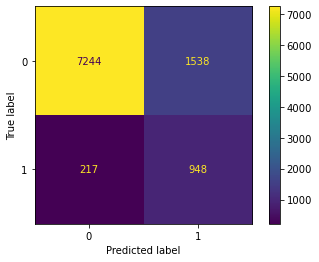

In [411]:
#confusion matrix for this undersampling model
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_under);

The undersampling with RandomUnderSampler(sampling_strategy='majority') model:

- predicted true positives (bottom right) 948 times (9.5% of all predictions, the baseline had 6.7%)
- predicted false positives (top right) 1,538 times (at a whopping 15.5%! The baseline was 5.0%)
- predicted true negatives (top left) 7,244 times (72.8%, baseline was 83.4%)
- predicted false negatives (bottom left) 217 times (2.2%, baseline was 5.1%)

To review, our last best model predicted:

- predicted true positives 687 times (6.9%)
- predicted false positives 480 times (4.8%)
- predicted true negatives 8,302 times (83.5%)
- predicted false negatives 478 times (4.8%)

It's great that the undersampling (strategy = 'majority') model has so few false negatives, but **I doubt 1,058 more wasted calls is worth 261 more term deposits. Or maybe it is, I don't really know, only the stakeholder would.** 

Now let's attempt to refine training data undersampling ratios and see if we improve from here. Below, I layout undersampling strategies for less drastic ratios: 90%, 80%, 70%, 60%, and 50% of the majority, then iterate through them to see if we find an improved model.

In [413]:
sampling_strategies = [{0:31626, 1:4645}, {0:28112, 1:4645}, {0:24598, 1:4645}, {0:21084, 1:4645}, {0:17570, 1:4645}]

In [414]:
recall_scores = []
auc_scores = []

sampling_strategies = sampling_strategies
for i in sampling_strategies:
    # define undersampling strategy
    undersample = RandomUnderSampler(random_state=713, sampling_strategy=i)
    # fit and apply the transform
    X_train_preprocessed_under, y_train_under = undersample.fit_resample(X_train_preprocessed, y_train)    
    #instantiate & fit the model to X_over & y_over
    clf_undersample_float = DecisionTreeClassifier(criterion='entropy', random_state=713)
    clf_undersample_float.fit(X_train_preprocessed_under, y_train_under)
    #make predictions for our evaluation metrics
    y_pred_test_under = clf_undersample_float.predict(X_test_preprocessed)
    #find & append recall scores
    recall_scores.append(recall_score(y_test, y_pred_test_under))
    #find & append auc scores
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_under)
    auc_scores.append(auc(fpr, tpr))

print("Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:")
print("recall scores:", recall_scores)
print("auc_scores:   ", auc_scores)

Recall & AUC scores for 0.9 through 0.5 sample_strategy undersampling dictionaries:
recall scores: [0.5939914163090129, 0.6180257510729614, 0.6171673819742489, 0.6686695278969957, 0.6686695278969957]
auc_scores:    [0.7664218069930399, 0.773599530057091, 0.7736258226200099, 0.791406046116569, 0.7888439873600215]


In [415]:
print('max recall score:', max(recall_scores))
print('max AUC score:', max(auc_scores))

max recall score: 0.6686695278969957
max AUC score: 0.791406046116569


It looks like the best recall and AUC pairing comes with an undersampling strategy of 60%. Let's evaluate more metrics with that specific model:

In [ ]:
#put undersampling at 60% model here and don't forget RandomUnderSampler random_state at 713

### SMOTE

I suppose the only thing left to try is SMOTE:

In [29]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=713)
X_train_ohe_smote, y_train_smote = smote.fit_resample(X_train_ohe, y_train)
y_train_smote.value_counts()

0    35140
1    35140
Name: y, dtype: int64

In [30]:
clf_smote = DecisionTreeClassifier(criterion='entropy', random_state=713)
clf_smote.fit(X_train_ohe_smote, y_train_smote)

DecisionTreeClassifier(criterion='entropy', random_state=713)

In [31]:
y_pred_test_smote = clf_smote.predict(X_test_ohe)

In [32]:
len(y_test)

9947

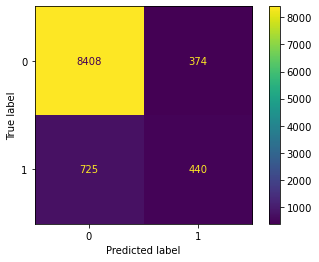

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_smote);

This SMOTE model:

- predicted true positives (bottom right) 440 times (4.4% of all predictions, the baseline had 4.8%)
- predicted false positives (top right) 374 times (3.8%, the baseline was 4.1%)
- predicted true negatives (top left) 8,408 times (85%, baseline was 84.2%)
- predicted false negatives (bottom left) 725 times (7.3%, baseline was 6.9%)

To review, our last best model (no over/under sampling, just a decision tree classifier with class_weight = 'balanced') showed the following results:

- predicted true positives (bottom right) 596 times (6% of all predictions)
- predicted false positives (top right) 631 times (6.3%)
- predicted true negatives (top left) 8,151 times (82%)
- predicted false negatives (bottom left) 569 times (5.7%)

This is a mixed bag, SMOTE wasn't as good as our baseline at true positives and false negatives, but it did improve on false positives and true negatives. However, each measure only worsened or improved somewhat slightly. 

When it comes to our only other improvement on the baseline (the DecisionTree with no over/under sampling, just class_weight = 'balanced'), SMOTE did substantially better with false positives & false negatives, but not as well on true positives & negatives. 

If our primary concern is recall, then false negatives are a big deal, and the first improved model (DecisionTree with no over/under sampling, just class_weight = 'balanced') has performed best there. 

Maybe we can try a model that's fed SMOTE-ed training data, but the DecisionTreeClassifier param is set to class_weight = 'balanced'? Oh and don't forget to run the other eval metrics on this current SMOTE model, genius.

In [34]:
print("SMOTE recall score:", recall_score(y_test, y_pred_test_smote))

SMOTE recall score: 0.3776824034334764


Jesus Christ. Okay what about AUC?

In [35]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_smote)
print("SMOTE AUC:", auc(fpr, tpr))

SMOTE AUC: 0.6675476467178769


Still worse than the baseline, let's just move on. 

In [36]:
clf_smote_and_balanced = DecisionTreeClassifier(criterion='entropy', random_state=713, class_weight="balanced")
clf_smote_and_balanced.fit(X_train_ohe_smote, y_train_smote)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=713)

In [37]:
y_pred_test_smote_and_balanced = clf_smote_and_balanced.predict(X_test_ohe)

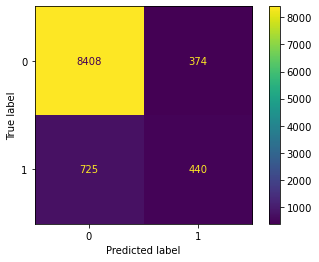

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_smote_and_balanced);

Ok, I had a feeling this would be redundant, it's the same as the SMOTE model. At least we know! Okay, at this point, I have done all I can for over and under-sampling and it's time to move on to pruning the decision tree. 

Our best model is the clf_balanced_class one, which takes in a "vanilla", non-pre-over-nor-under-sampled X_train_ohe & y_train, and is just a DecisionTreeClassifier with class_weight="balanced", so it *does* address class imbalance with balanced weights "inversely proportional to class frequencies".

## Decision Tree Pruning

Next, we'll see whether tuning the model's 'max_depth', 'min_samples_split', and 'min_samples_leaf' hyperparameters help improve results. If they don't, so help me God, I am so tired of working hard and having nothing to show for it. 

First, let's bring back the evaluation metrics for our best model:

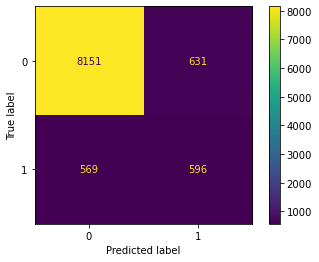

In [41]:
y_pred_test = clf_balanced_class.predict(X_test_ohe)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test);

In [42]:
print('recall:', recall_score(y_test, y_pred_test))

recall: 0.511587982832618


In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
print('AUC:', auc(fpr, tpr))

AUC: 0.7198682341856099


In [44]:
balanced_class_neg_log_loss_cv = cross_val_score(clf_balanced_class, X_test_ohe, y_test, scoring='neg_log_loss')
balanced_class_log_loss = -(balanced_class_neg_log_loss_cv.mean())
balanced_class_log_loss

5.8701768942159855

Great stuff, now let's try iterating through various modes for the model's 'max_depth' hyperparameter first:

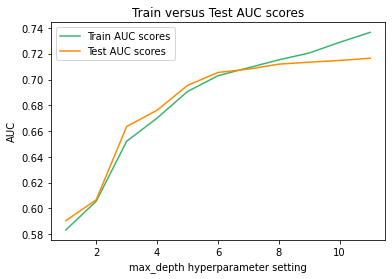

In [46]:
#Let's try up to 12 for now since it takes a minute for my laptop to run just one model
max_depth = np.arange(1,13)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in max_depth:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion="entropy", 
                                      random_state=713, 
                                      class_weight="balanced",
                                      max_depth=i)
    temp_clf.fit(X_train_ohe, y_train)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_ohe)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_ohe)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
#Plot
fig, ax = plt.subplots()
ax.plot(max_depth, train_auc_values, color='mediumseagreen', label='Train AUC scores')
ax.plot(max_depth, test_auc_values, color='darkorange', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('max_depth hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(3, ymin=0.70, ymax=0.935, color='k', linestyle='--', label="my best guess")
ax.legend();

Nice, it looks like the test scores are starting to even out, but they're still on the rise. Let's adjust our max_depth range to, say, 6 through 20:

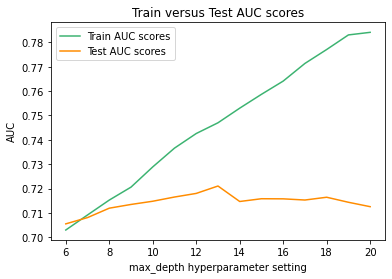

In [47]:
max_depth = np.arange(6,21)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in max_depth:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion="entropy", 
                                      random_state=713, 
                                      class_weight="balanced",
                                      max_depth=i)
    temp_clf.fit(X_train_ohe, y_train)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_ohe)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_ohe)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
#Plot
fig, ax = plt.subplots()
ax.plot(max_depth, train_auc_values, color='mediumseagreen', label='Train AUC scores')
ax.plot(max_depth, test_auc_values, color='darkorange', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('max_depth hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(3, ymin=0.70, ymax=0.935, color='k', linestyle='--', label="my best guess")
ax.legend();

Alright, we have an optimal max_depth setting of 13, which results in an AUC of around 0.72. That's pretty close to our current model's AUC, so let's see exactly what that is:

In [51]:
max(test_auc_values)

0.7210239340516058

Good news, that's the best AUC so far, even if it's just a little better than the current model's AUC of 0.7199. Before refining more hyperparams, let's stop for a second and evaluate this model with max_depth=13 in regards to recall & neg_log_loss:

In [28]:
clf_balanced_class_md_13 = DecisionTreeClassifier(criterion='entropy', 
                                                  random_state=713, 
                                                  class_weight="balanced", 
                                                  max_depth=13)
clf_balanced_class_md_13.fit(X_train_ohe, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=13, random_state=713)

In [29]:
y_pred_test_bcmd13 = clf_balanced_class_md_13.predict(X_test_ohe)
recall_score(y_test, y_pred_test_bcmd13)

0.5407725321888412

In [30]:
f1_score(y_test, y_pred_test_bcmd13)

0.473328324567994

That's the best recall score we've seen so far. Yes, it *is* a slight nudge upward, but still a bigger improvement over 0.5115 than we've seen so far. What about log_loss?

In [55]:
balanced_class_neg_log_loss_cv = cross_val_score(clf_balanced_class_md_13, X_test_ohe, y_test, scoring='neg_log_loss')
balanced_class_log_loss = -(balanced_class_neg_log_loss_cv.mean())
balanced_class_log_loss

1.314097115635142

Wow, that's a lot better than the non-max-depth-optimized score of 5.87! Okay, now let's move on to tuning the 'min_samples_splits' hyperparam.

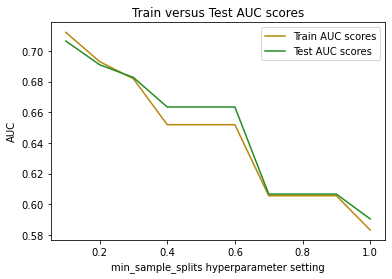

In [56]:
#I think we do this ratio with floats, at least at first
min_samples_split = np.arange(0.1,1.1,0.1)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in min_samples_split:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion='entropy', 
                                      random_state=713, 
                                      class_weight="balanced",
                                      min_samples_split=i)
    temp_clf.fit(X_train_ohe, y_train)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_ohe)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_ohe)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
#Plot
fig, ax = plt.subplots()
ax.plot(min_samples_split, train_auc_values, color='darkgoldenrod', label='Train AUC scores')
ax.plot(min_samples_split, test_auc_values, color='forestgreen', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('min_sample_splits hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(0.7, ymin=0.70, ymax=0.93, color='k', linestyle='--', label="my best guess")
ax.legend();

This doesn't help, so let's try adjusting 'min_samples_leaf' 

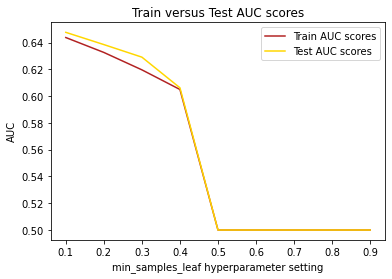

In [57]:
# Calculate the optimal value for minimum sample leafs
min_samples_leaf = np.arange(0.1,1.0,0.1)

#setup lists for plotting 
train_auc_values = []
test_auc_values = []

#iterating through max_values and filling the lists above
for i in min_samples_leaf:
    #initialize & train the classifier
    temp_clf = DecisionTreeClassifier(criterion='entropy', 
                                      random_state=713, 
                                      class_weight="balanced",
                                      min_samples_leaf=i)
    temp_clf.fit(X_train_ohe, y_train)
    #calculate & append training AUC
    y_train_hat = temp_clf.predict(X_train_ohe)
    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_hat)
    train_roc_auc = auc(train_fpr, train_tpr)
    train_auc_values.append(train_roc_auc)
    #calculate & append AUC
    y_test_hat = temp_clf.predict(X_test_ohe)
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_hat)
    test_roc_auc = auc(test_fpr, test_tpr)
    test_auc_values.append(test_roc_auc)
#Plot
fig, ax = plt.subplots()
ax.plot(min_samples_leaf, train_auc_values, color='firebrick', label='Train AUC scores')
ax.plot(min_samples_leaf, test_auc_values, color='gold', label='Test AUC scores')
ax.set_title('Train versus Test AUC scores')
ax.set_xlabel('min_samples_leaf hyperparameter setting')
ax.set_ylabel('AUC')
#ax.vlines(0.2, ymin=0.5, ymax=0.8, color='k', linestyle='--', label="my best guess")
ax.legend();

Ok...tuning 'min_sample_leaf' along with 'min_samples_split' only worsens the model, so there we have it: **clf_balanced_class_md_13 is the best decision tree model**. One thing we haven't done yet is investigate its Confusion Matrix:

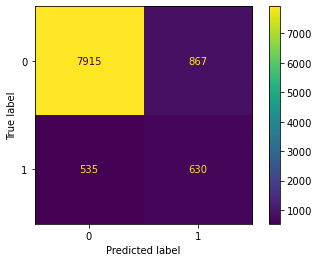

In [61]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_bcmd13);

This decision tree with *class_weight = 'balanced'* and *max_depth = 13* model:

- predicted true positives (bottom right) 630 times (6.3% of all predictions, the baseline had 4.8%)
- predicted false positives (top right) 867 times (8.7%, the baseline was 4.1%)
- predicted true negatives (top left) 7,915 times (80%, baseline was 84.2%)
- predicted false negatives (bottom left) 535 times (5.4%, baseline was 6.9%)

To review, our last best model (no over/under sampling, just a decision tree classifier with class_weight = 'balanced') showed the following results:

- predicted true positives (bottom right) 596 times (6% of all predictions)
- predicted false positives (top right) 631 times (6.3%)
- predicted true negatives (top left) 8,151 times (82%)
- predicted false negatives (bottom left) 569 times (5.7%)

So, adding in the max_depth=13 param may have improved the recall, AUC, and log_loss scores as well as increasing true positives, but it also increased the number of false positives *and* negatives while decreasing the number of true negatives. 

I think this means that the max_depth = 13 model is a better model overall, especially when you consider its recall, AUC, and log-loss scores. However, it does result in 34 more false negatives, but then again, it results in 34 more true positives, so that cancels out. Oh wait, I think that's a redundant observation, like that's just the nature of confusion matrices. 

Next, max_depth = 13 will result in 236 more false positives, which means more wasted money on the call center...so **I think setting max_depth = 13 means 34 fewer missed-out-on term deposits at the expense of 236 more wasted calls.** Is that worth it? I guess it's up to the stakeholder to know, since they'd have more info on what a term deposit would net them as opposed to paying for 236 unsuccessful calls. 

Next steps: 

1. Did I run those 'min_sample_leaf' along with 'min_samples_split' hyperparam nodes correctly? I think they work fine as floats because they're proportions as opposed to ints as exact numbers of leaves/splits.
2. What are the params of this dccwbmd13 model? Is that a thing? <----no, it is not.
3. Am I interpreting the recall and AUC scores a little too broadly? They are relative metrics that depend on the nature of the data.
4. LogisticRegression model

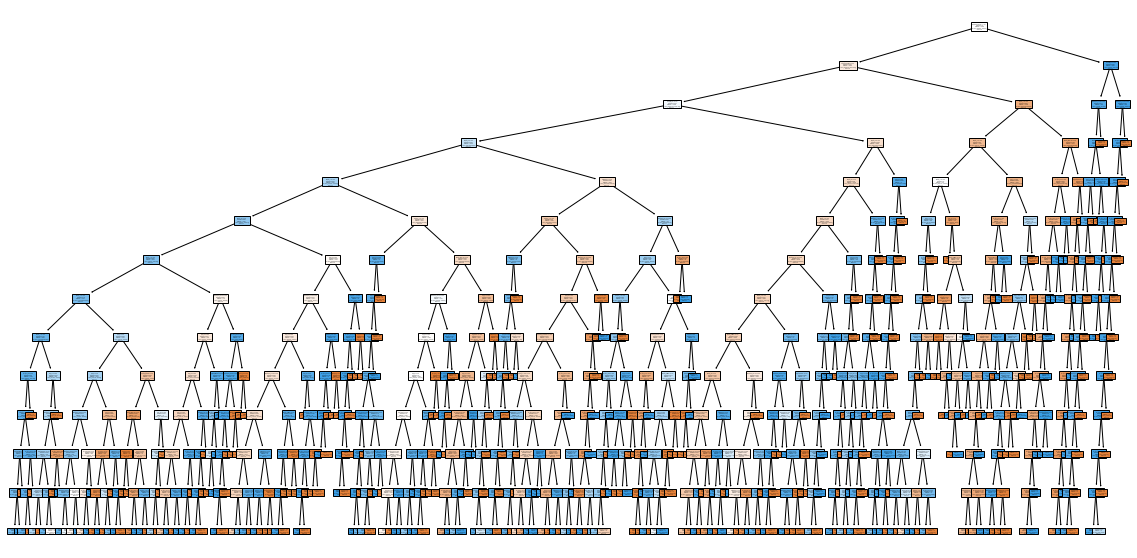

<Figure size 432x288 with 0 Axes>

In [42]:
#Checking out the tree plot
fig, ax = plt.subplots(figsize=(20,10))
tree.plot_tree(clf_balanced_class_md_13,
              feature_names = ohe_df.columns,
              class_names = np.unique(y).astype('str'),
              filled=True)
plt.show();

In [33]:
#import graphviz as gv

#dot_file = tree.export_graphviz(clf_balanced_class_md_13, out_file='final_decision_tree.png')
#graph = gv.Source(dot_file)
#graph.render('dot_file')

In [34]:
#dot_data = tree.export_graphviz(clf_balanced_class_md_13, out_file=None, 
#                                feature_names=ohe_df.columns,  
#                                filled=True)
#gv.Source(dot_data, format="png") 

Well, that looks a lot more reasonable than the leviathan horror we saw in the baseline model's tree plot. This is still not easy to interpret, but we're focused on predictions here, not necessarily a thorough understanding of how the model explains the data. 

So, with AUC at 0.721, recall at 0.541, and log-loss at 1.314 (which we can only interpret in relation to the baseline's 5.87), the 34 more term deposits versus 236 more wasted calls argument is backed by a "somewhere between okay and good" model. The AUC score is "good", the recall score is just passable, and the log-loss reduction means we made some substantial progress over the baseline. 

**You know, one other thing I need to be able to say is "these are the attributes you should consider if gaining 34 term deposits is worth paying for 236 wasted calls". How do I find that information? Or do I not because it's too large and they simply run this model on new clients?**

## Logistic Regression model

Our next step is to try all this again with a LogisticRegression model. I hope the evaluation metrics can be the same.

In [43]:
from sklearn.linear_model import LogisticRegression
#instantiate and fit the baseline model
logit_baseline_model = LogisticRegression(random_state=713)
logit_baseline_model.fit(X_train_ohe, y_train)

C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=713)

In [44]:
#make predictions
y_pred_train_baseline = logit_baseline_model.predict(X_train_ohe)
y_pred_test_baseline = logit_baseline_model.predict(X_test_ohe)

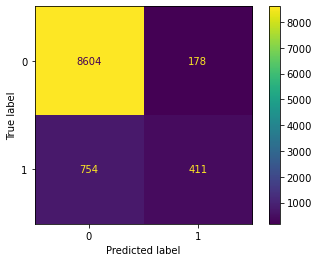

In [39]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_baseline);

This baseline Logistic Regression model:

- predicted true positives (bottom right) 411 times (4.1%, the decision tree baseline had 4.8%, the optimal one had 6.3%)
- predicted false positives (top right) 178 times (1.8%, the decision tree baseline was 4.1%, the optimal one had 8.7%)
- predicted true negatives (top left) 8,604 times (87%, the decision tree baseline was 84.2%, the optimal one had 80%)
- predicted false negatives (bottom left) 754 times (7.6%, the decision treebaseline was 6.9%, the optimal one had 5.4%)

While this is a mixed result in comparison to the decision tree baseline, overall it seems a little better, especially with the big drop in false positives and increase in true negatives. 

Compared to the optimized decision tree model above, it's still the same overall story just with different degrees. 

Even while this Logit baseline looks good overall, the big problem is its false negatives; they are problematically high for our stakeholder's concerns. Let's see what we can do to try and lower them. First things first, however, let's run the evaluation metrics here as we did with our decision tree models:

In [40]:
recall_score(y_test, y_pred_test_baseline)

0.35278969957081546

Terrible, as we expected from our confusion matrix. What about AUC?

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_baseline)
print('test AUC:', auc(fpr, tpr))

test AUC: 0.6662604840372865


Not great, not terrible, but definitely needs improvement. 

In [46]:
from sklearn.model_selection import cross_val_score
baseline_neg_log_loss_cv_train = cross_val_score(logit_baseline_model, X_train_ohe, y_train, scoring='neg_log_loss')
baseline_log_loss_train= -(baseline_neg_log_loss_cv_train.mean())
print('training log loss score:', baseline_log_loss_train)
#test
baseline_neg_log_loss_cv_test = cross_val_score(logit_baseline_model, X_test_ohe, y_test, scoring='neg_log_loss')
baseline_log_loss_test = -(baseline_neg_log_loss_cv_test.mean())
print('testing log loss score:', baseline_log_loss_test)

C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

training log loss score: 0.23420182748801288


C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

testing log loss score: 0.271182752852691


C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Ok, good to have a baseline. I guess I'll need to fix those errors with the stuff I did in the last cumulative lab. 

Anyway, let's begin with the same steps we took for the decision tree and see whether under/over-sampling will help. When I started that process with decision trees, I just added a class_weight='balanced' hyperparam. I can do the same thing here, so let's try that first:

In [47]:
logit_baseline_model_balanced = LogisticRegression(random_state=713, class_weight="balanced")
logit_baseline_model_balanced.fit(X_train_ohe, y_train)

C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=713)

In [49]:
#make predictions
y_pred_train_balanced = logit_baseline_model_balanced.predict(X_train_ohe)
y_pred_test_balanced = logit_baseline_model_balanced.predict(X_test_ohe)

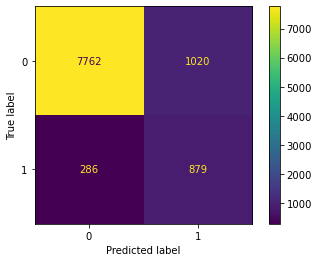

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_balanced);

This 'balanced' Logistic Regression model:

- predicted true positives (bottom right) 879 times (8.8%, our logit baseline had 4.1%, the optimal d.t. had 6.3%)
- predicted false positives (top right) 1,020 times (10.3%, our logit baseline had 1.8%, the optimal d.t. had 8.7%)
- predicted true negatives (top left) 7,762 times (78%, our logit baseline had 87%, the optimal d.t. had 80%)
- predicted false negatives (bottom left) 286 times (2.9%, our logit baseline had 7.6%, the optimal one had 5.4%)

On one hand, that is a terrible amount of false positives, but on the other hand, it's a great number of false negatives, which is more important for our stakeholder. 

Specifically, **this model boasts 249 fewer missed term deposits than our optimized decision tree model, but at the expense of 153 more false positives.** Again, it would be up to the stakeholder to determine whether that's worth it since they have an idea of what each term deposit gains them as opposed to what each wasted call center call costs. 

Hopefully, we can improve on this model further and reduce the number of false positives without sacrificing (too many) false negatives. First, however, let's run the remaining evaluation metrics.

In [51]:
recall_score(y_test, y_pred_test_balanced)

0.7545064377682403

Wow, what an improvement. Ok now AUC:

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test_balanced)
print('test AUC:', auc(fpr, tpr))

test AUC: 0.8191798870690439


Gracious, that's the best AUC we've seen so far. I did all that work on a decision tree and this ever-so-slightly-tweaked Logit model is pummeling it...not sure how I feel about that. 

In [53]:
baseline_neg_log_loss_cv_train = cross_val_score(logit_baseline_model_balanced, X_train_ohe, y_train, scoring='neg_log_loss')
baseline_log_loss_train= -(baseline_neg_log_loss_cv_train.mean())
print('training log loss score:', baseline_log_loss_train)
#test
baseline_neg_log_loss_cv_test = cross_val_score(logit_baseline_model_balanced, X_test_ohe, y_test, scoring='neg_log_loss')
baseline_log_loss_test = -(baseline_neg_log_loss_cv_test.mean())
print('testing log loss score:', baseline_log_loss_test)

C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

training log loss score: 0.3278132466366156


C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

testing log loss score: 0.34492651210193526


C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Wow, that's pretty low. Okay well, let's try feeding it under & over-sampled inputs. 

In [56]:
logit_baseline_model_oversample_minority = LogisticRegression(random_state=713)
logit_baseline_model_oversample_minority.fit(X_train_ohe_over, y_train_over)

C:\Users\joelm\anaconda3again\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=713)

In [57]:
#make predictions
y_pred_train_oversample_minority = logit_baseline_model_oversample_minority.predict(X_train_ohe_over)
y_pred_test_oversample_minority = logit_baseline_model_oversample_minority.predict(X_test_ohe)

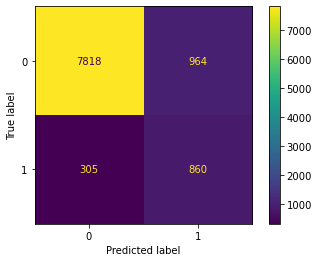

In [58]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_oversample_minority);